Setup
====

In [1]:
class_system = 'IPC4'

In [2]:
import pandas as pd
import seaborn as sns
import powerlaw
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pylab
pylab.rcParams['xtick.major.pad']='4'
pylab.rcParams['ytick.major.pad']='4'
pylab.rcParams['figure.subplot.left']='0'
pylab.rcParams['figure.subplot.right']='1'
pylab.rcParams['figure.subplot.bottom']='0'
pylab.rcParams['figure.subplot.top']='1'
pylab.rcParams['savefig.pad_inches']='0'
#pylab.rcParams['font.sans-serif']='Arial'

from matplotlib import rc
rc('font', family='sans-serif')
rc('font', size=10.0)
rc('text', usetex=False)


from matplotlib.font_manager import FontProperties

panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(10.0)
panel_label_font.set_family("sans-serif")

In [4]:
sns.set_style("darkgrid")
fig_one_col = 3.4252#3.35
fig_two_col = 7.007874#6.93

In [5]:
figures = []
# figures_directory = '/home/jeffrey_alstott/Dropbox/sharelatex/normalizing-technology-networks/normalizing-technology-networks/figs/'
figures_directory = '../manuscript/figs/'
save_as_manuscript_figures = False

In [6]:
def pretty_axis_labels(ax=None, wraplength=30, **kwargs):
    import textwrap
    if not ax:
        ax = gca()
    x = ax.get_xlabel()
    y = ax.get_ylabel()
    ax.set_xlabel("\n".join(textwrap.wrap(x.replace("_"," "), wraplength)), **kwargs)
    ax.set_ylabel("\n".join(textwrap.wrap(y.replace("_"," "), wraplength)), **kwargs)  
    
def pretty_titles(ax=None, wraplength=30, **kwargs):
    import textwrap
    if not ax:
        ax = gca()
    t = ax.get_title()
    ax.set_title("\n".join(textwrap.wrap(t.replace("_"," "), wraplength)), **kwargs)
    
def pretty_tick_labels(ax=None, wraplength=30,axis='y', **kwargs):
    import textwrap
    if not ax:
        ax = gca()
    if 'x' in axis:
        X = ax.get_xticklabels()
        ax.set_xticklabels(["\n".join(textwrap.wrap(x.get_text().replace("_"," "), wraplength)) for x in X], **kwargs)
    if 'y' in axis:
        Y = ax.get_yticklabels()
        ax.set_yticklabels(["\n".join(textwrap.wrap(y.get_text().replace("_"," "), wraplength)) for y in Y], **kwargs)  

In [7]:
def clean_measure_names(df, include_country=False):
    

    renames = [('Class_Cites_Class_Count', 
                'Direct Citation'),
               ('Class_CoCitation_Count', 
                'Co-Citation'),
               ('Class_Cites_Class_Input_Cosine_Similarity', 
                'Cosine Sim.,\nInputs'),
               ('Class_Cites_Class_Output_Cosine_Similarity', 
                'Cosine Sim.,\nOutputs'),
               ('Class_Cites_Patent_Input_Cosine_Similarity', 
                'Cosine Sim.,\nInputs, High Res.'),
               ('Patent_Cites_Class_Output_Cosine_Similarity', 
                'Cosine Sim.,\nOutputs, High Res.'),
#                ('Class_CoClassification_Count', 
#                 'Co-Classification'),
               ('Class_CoOccurrence_Count_PID', 
                'Co-Classification'),               
               ('Class_CoOccurrence_Count_Inventor', 
                "Co-Occurrence,\nInventors' Patents"),
               ('Class_CoOccurrence_Count_Firm', 
                "Co-Occurrence,\nFirms' Patents"),
                    ]
    if include_country:
        renames.append(('Class_CoOccurrence_Count_Country', 
                        "Co-Occurrence,\nCountries' Patents")
                      )
    new_metric_names = pd.DataFrame(renames, columns=["Old_Name",
                                                     "New_Name"])
    
    rename_dictionary = {}
    for i in new_metric_names.index:
        rename_dictionary[new_metric_names.ix[i,"Old_Name"]] = new_metric_names.ix[i,"New_Name"]
    df.rename(rename_dictionary, inplace=True)

    for metric in df.items:
        if metric not in new_metric_names["New_Name"].values:
            df.drop(metric, inplace=True,axis='items')
#     return
    return df.reindex_axis(new_metric_names["New_Name"], axis='items')

def drop_diagonal(df):
    for item in df.items:
        fill_diagonal(df[item].values, 0)
        
def off_diagonal(df):
    return extract(1 -  eye(len(df)), df)

In [10]:
# data_directory = '../data/'
# target_year = 2010

In [11]:
networks_store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/class_relatedness_networks.h5')

In [12]:
empirical = networks_store['empirical_%s'%class_system].ix[:, target_year]

In [13]:
# if class_system == 'IPC':
#     empirical['Class_CoClassification_Count'] = networks_store['empirical_%s'%class_system].ix['Class_CoClassification_Count', 2006]
# if class_system == 'IPC4':
#     empirical['Class_CoOccurrence_Count_PID'] = networks_store['empirical_%s'%class_system].ix['Class_CoOccurrence_Count_PID', 2006]
# empirical = empirical.rename({'Class_CoClassification_Count': 'Class_CoOccurrence_Count_PID'})
empirical = clean_measure_names(empirical)
drop_diagonal(empirical)

In [18]:
# for item in empirical.items:
#     empirical.ix[item].to_csv(item.replace("\n", " ")+"_empirical.csv")

Size and Time Structure of Citations
===

In [27]:
citations_store = pd.HDFStore(data_directory+'citations_organized.h5')

In [28]:
citations = citations_store['citations']

In [29]:
class_lookup = citations_store['%s_class_lookup'%class_system]
patent_attributes = citations_store['patent_attributes']

In [30]:
print("%i patents"%patent_attributes.shape[0])

3911054 patents


In [31]:
for column in citations.columns:
    if class_system in column:
        new_name = column.replace('_'+class_system, "")
        citations.rename(columns={column: new_name}, inplace=True)

In [32]:
for column in patent_attributes.columns:
    if class_system in column:
        new_name = column.replace('_'+class_system, "")
        patent_attributes.rename(columns={column: new_name}, inplace=True)

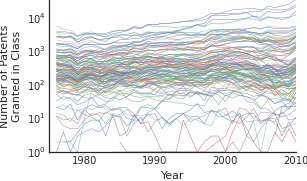

In [25]:
class_counts = pd.DataFrame(patent_attributes.groupby(['Class', 'Year'])['Class'].count())
class_counts.rename(columns={"Class": "Count"}, inplace=True)
class_counts.reset_index(inplace=True)

#with sns.color_palette("rainbow", len(class_lookup.index)):
fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

for this_class in class_lookup.values:
    this_df = class_counts[class_counts['Class']==this_class]
    ax.plot(this_df['Year'], this_df['Count'], linewidth=.4)

xticks([1980, 1990, 2000, 2010])
yscale('log')
ylim(ymax=max(class_counts['Count']))
ylabel("Number of Patents\nGranted in Class")
xlabel("Year")
sns.despine()

In [26]:
# class_citation_counts = pd.DataFrame(citations.groupby(['Class_Citing_Patent', 'Year_Citing_Patent'])['Same_Class'].count()).reset_index()
# class_citation_counts.rename(columns={'Class_Citing_Patent': 'Class',
#                                      'Year_Citing_Patent': 'Year',
#                                      'Same_Class': 'Count'},
#                             inplace=True)
# class_citation_counts =(class_citation_counts.set_index(['Class', 'Year']) / 
#                         class_counts.set_index(['Class', 'Year'])).reset_index()
class_citation_counts = pd.DataFrame(patent_attributes.groupby(['Class', 'Year'])['Citations_Made'].mean()).reset_index()

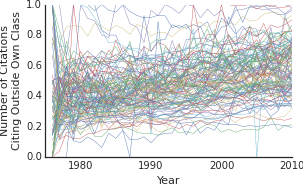

In [27]:
grouper = citations.groupby(['Class_Citing_Patent', 'Year_Citing_Patent'])['Same_Class']

class_same_class_counts = pd.DataFrame(grouper.sum()/grouper.count())

class_same_class_counts['Different_Class'] = 1-class_same_class_counts['Same_Class']
class_same_class_counts.reset_index(inplace=True)

class_same_class_counts.rename(columns={"Year_Citing_Patent": "Year"}, inplace=True)


fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

for this_class in class_lookup.values:
    this_df = class_same_class_counts[class_same_class_counts['Class_Citing_Patent']==this_class]
    ax.plot(this_df['Year'], this_df['Different_Class'], linewidth=.4)

xticks([1980, 1990, 2000, 2010])
ylabel("Number of Citations\nCiting Outside Own Class")
xlabel("Year")
sns.despine()

In [33]:
###Calculate number of patents in each class

patent_count = patent_attributes['Class'].value_counts()
patent_count = patent_count.ix[class_lookup.ix[empirical.major_axis].values].fillna(0)
patent_count_links = outer(patent_count.values, patent_count.values)

# ##Number of citing patents and cited patents in each class
# citing_patent_count = citations.drop_duplicates(['Citing_Patent'])['Class_Citing_Patent'].value_counts()
# cited_patent_count = citations.drop_duplicates(['Cited_Patent'])['Class_Cited_Patent'].value_counts()

# ##Need to rearrange to match with our networks' ordering
# citing_patent_count = citing_patent_count.ix[class_lookup.ix[empirical.major_axis].values]
# cited_patent_count = cited_patent_count.ix[class_lookup.ix[empirical.major_axis].values]

# ##Create an link between each class, weighted as the product of the patent counts in each class
# citing_patent_count_links = outer(citing_patent_count.values, citing_patent_count.values)
# cited_patent_count_links = outer(cited_patent_count.values, cited_patent_count.values)

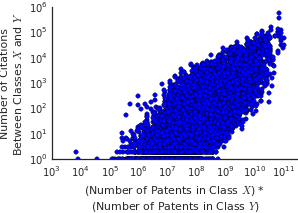

In [29]:
fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

ax.scatter(patent_count_links.ravel(),
       empirical.ix['Direct Citation'].values.ravel()
       )
yscale('log')
xscale('log')
ylim(ymin=1)
xlim(xmin=1000, xmax=10**11.5)
sns.despine()
ylabel(r"Number of Citations"+"\n"+"Between Classes $X$ and $Y$")
xlabel(r"(Number of Patents in Class $X$) *"+"\n"+r"(Number of Patents in Class $Y$)")

In [30]:
citations['Year_Difference'] = citations.Year_Citing_Patent - citations.Year_Cited_Patent
year_range = max(citations.Year_Difference)

In [31]:
age_probabilities = citations.groupby('Year_Citing_Patent')['Year_Difference'].apply(lambda d:histogram(d,
                                     bins=arange(year_range), 
                                     normed=True
                                    )[0])

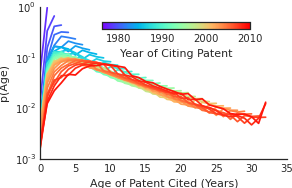

In [32]:
with sns.color_palette("rainbow", year_range+1):
    fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
    ax = fig.add_subplot(1,1,1)

    for i in age_probabilities.index:
        d = copy(age_probabilities.ix[i])
        d[d==0] = nan
        ax.plot(d)

    xlabel("Age of Patent Cited (Years)")
    ylabel("p(Age)")
    yscale('log')
    
    cmap = cm.rainbow
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=citations['Year_Citing_Patent'].min(), vmax=citations['Year_Citing_Patent'].max())

#    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    ax2 = fig.add_axes([0.25, 0.85, 0.6, 0.05])
    
    cbar = mpl.colorbar.ColorbarBase(ax2, 
                                     cmap=cmap,
                                     norm=norm,
                                     orientation='horizontal',
                                     label='Year of Citing Patent',
                                    ticks=[1980, 1990, 2000, 2010])
    
    sns.despine()

In [33]:
age_probabilities = citations.groupby('Class_Citing_Patent')['Year_Difference'].apply(lambda d:histogram(d,
                                     bins=arange(year_range), 
                                     normed=True
                                    )[0])

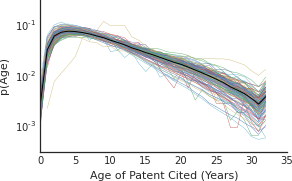

In [34]:
fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

for i in age_probabilities.index:
    d = copy(age_probabilities.ix[i])
    d[d==0] = nan
    ax.plot(d, linewidth=.4)
ax.plot(age_probabilities.mean(), color='black', linewidth=1)
xlabel("Age of Patent Cited (Years)")
ylabel("p(Age)")
yscale('log')
ylim(ymin=10**-3.5,
    ymax=10**-.5)

sns.despine()

In [35]:
def expanding_weighted_mean(df):    
    return pd.rolling_apply(arange(len(df)),
                            len(df),
                            lambda ii: average(df.iloc[ii]['Year'], 
                                               weights=df.iloc[ii]['Count']),
                            min_periods=1)

In [36]:
q = class_counts.groupby(['Class'])[['Count', 
                                'Year']].apply(expanding_weighted_mean)
class_counts['Average_Year'] = concatenate(q.values)
class_counts['Average_Age'] = class_counts['Year'] - class_counts['Average_Year']

In [37]:
def add_panel_label(ax=None,
               letter=None,
               coord=None):
    global panel_label
    if letter is None:
        letter = panel_label
        panel_label = chr(ord(panel_label) + 1)
    if ax is None:
        ax = gca()
    if coord is None:
        coord = annotate_coord
    
    ax.text(coord[0], coord[1], letter, 
        transform=ax.transAxes, fontproperties=panel_label_font)

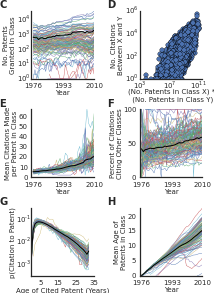

In [38]:
sns.set_style("white")

# fig = figure(figsize=(fig_one_col*1.618, fig_one_col))
fig = figure(figsize=(fig_two_col, 6.5))#fig_two_col/1.618))
nrows=5
ncols=5
this_ax = 0
annotate_coord = (-.5, 1.05)
panel_label = "C"

these_font_size = 7
these_label_pad = 1

# this_ax +=1
this_ax = 4
ax = fig.add_subplot(nrows, ncols, this_ax)


for this_class in class_lookup.values:
    this_df = class_counts[class_counts['Class']==this_class]
    ax.plot(this_df['Year'], this_df['Count'], linewidth=.4)

this_df = class_counts.groupby('Year')['Count'].mean()
ax.plot(this_df.index, this_df, linewidth=1, color='k')

xticks([1976, 1993, 2010], fontsize=these_font_size)
yscale('log')
yticks([1, 10, 100, 1000, 10000], fontsize=these_font_size)

ylim(ymax=max(class_counts['Count']))
ylabel("No. Patents\nGranted in Class", fontsize=these_font_size, labelpad=these_label_pad)
xlabel("Year", fontsize=these_font_size, labelpad=these_label_pad)
ax.tick_params(axis='y', which='major', pad=1)

######
this_ax +=1
# this_ax += ncols
ax = fig.add_subplot(nrows, ncols, this_ax)
ax.scatter(patent_count_links.ravel(),
       empirical.ix['Direct Citation'].values.ravel(),
           c=sns.color_palette()[0]
       )
yscale('log')
xscale('log')
ylim(ymin=1)
xlim(xmin=10**3,xmax=10**11.5)
xticks([10**3, 10**7, 10**11], fontsize=these_font_size)
yticks([1, 10**2, 10**4,10**6], fontsize=these_font_size)
# ylabel(r"No. Citations"+"\n"+r"Between $X$ and $Y$",
#       fontsize=8)
# xlabel(r"(No. Patents in Class $X$) *"+"\n"+r"(No. Patents in Class $Y$)",
#       fontsize=6)

ylabel("No. Citations\nBetween X and Y", 
       fontsize=these_font_size, labelpad=these_label_pad)
xlabel("(No. Patents in Class X) *\n (No. Patents in Class Y)",
      fontsize=these_font_size, labelpad=-4)#these_label_pad)

ax.tick_params(axis='both', which='major', pad=1)

#####
# this_ax += ncols
this_ax += ncols-1

ax = fig.add_subplot(nrows, ncols, this_ax)

for this_class in class_lookup.values:
    this_df = class_citation_counts[class_citation_counts['Class']==this_class]
    ax.plot(this_df['Year'], this_df['Citations_Made'], linewidth=.4)

this_df = class_citation_counts.groupby('Year')['Citations_Made'].mean()
ax.plot(this_df.index, this_df, linewidth=1, color='k')

xticks([1976, 1993, 2010], fontsize=these_font_size)
ylim(ymax=max(class_citation_counts['Citations_Made']))
#yscale('log')
yticks(fontsize=these_font_size)

ylabel("Mean Citations Made\nper Patent in Class", fontsize=these_font_size, labelpad=these_label_pad)
xlabel("Year", fontsize=these_font_size, labelpad=these_label_pad)


#####
# this_ax +=1
this_ax +=1
ax = fig.add_subplot(nrows, ncols, this_ax)


for this_class in class_lookup.values:
    this_df = class_same_class_counts[class_same_class_counts['Class_Citing_Patent']==this_class]
    ax.plot(this_df['Year'], this_df['Different_Class']*100, linewidth=.4)

this_df = class_same_class_counts.groupby('Year')['Different_Class'].mean()*100
ax.plot(this_df.index, this_df, linewidth=1, color='k')

xticks([1976, 1993, 2010], fontsize=these_font_size)
yticks([0, 50, 100], fontsize=these_font_size)

ylabel("Percent of Citations\nCiting Other Classes", fontsize=these_font_size, labelpad=these_label_pad)
xlabel("Year", fontsize=these_font_size, labelpad=these_label_pad)


#####
# this_ax +=1
this_ax += ncols-1
ax = fig.add_subplot(nrows, ncols, this_ax)

for i in age_probabilities.index:
    d = copy(age_probabilities.ix[i])
    d[d==0] = nan
    ax.plot(d, linewidth=.4)
ax.plot(age_probabilities.mean(), color='black', linewidth=1)
xlabel("Age of Cited Patent (Years)", fontsize=these_font_size, labelpad=these_label_pad)
ylabel("p(Citation to Patent)", fontsize=these_font_size, labelpad=these_label_pad)
yscale('log')
ylim(ymin=10**-3.5,
    ymax=10**-.5)
xticks([5, 15, 25, 35], fontsize=these_font_size)
yticks([10**-3, 10**-2, 10**-1], fontsize=these_font_size)

ax.tick_params(axis='y', which='major', pad=0)

###
# colors = sns.color_palette("husl", year_range+2)[:33]
# colors = sns.husl_palette(year_range+2, l=.6)[:33]
# ax.set_color_cycle(colors)

# ax.plot(all_age_probabilities.T)
# ax.set_xlabel("Age of Patent\nCited (Years)", fontsize=these_font_size, labelpad=these_label_pad)
# ax.set_ylabel("p(Age)", fontsize=these_font_size, labelpad=these_label_pad)
# xticks([5, 15, 25, 35], fontsize=8)
# yscale('log')
# yticks([10**-3, 10**-2, 10**-1, 10**0], fontsize=these_font_size)
# sns.despine(fig,ax)
# add_panel_label()

# cmap = mpl.colors.ListedColormap(colors)

# from matplotlib.colors import Normalize
# norm = Normalize(vmin=min(all_years), vmax=max(all_years))

# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# ax2 = inset_axes(ax,
#                 width="70%", # width = 10% of parent_bbox width
#                 height="10%", # height : 50%
#                 loc=1,
#                 bbox_to_anchor=(.02, .02, 1, 1),
#                bbox_transform=ax.transAxes,
#                borderpad=0,
#                    )
# cbar = mpl.colorbar.ColorbarBase(ax2, 
#                                  cmap=cmap,
#                                  norm=norm,
#                                  orientation='horizontal',
#                                  label='Citing Patent Year',
#                                 ticks=[1976, 1993, 2010])
# cbar.ax.tick_params(labelsize=max(6, these_font_size-1))
# cbar.ax.set_xlabel('Citing Patent Year', fontsize=max(6, these_font_size-1), labelpad=0)

####
this_ax +=1
ax = fig.add_subplot(nrows, ncols, this_ax)


for this_class in class_lookup.values:
    this_df = class_counts[class_counts['Class']==this_class]
    ax.plot(this_df['Year'], this_df['Average_Age'], linewidth=.4)

this_df = class_counts.groupby('Year')['Average_Age'].mean()
ax.plot(this_df.index, this_df, linewidth=1, color='k')

xticks([1976, 1993, 2010], fontsize=these_font_size)
# yscale('log')
yticks(fontsize=these_font_size)

ylim(ymax=max(class_counts['Average_Age']))
ylabel("Mean Age of\nPatents in Class", fontsize=these_font_size, labelpad=these_label_pad)
xlabel("Year", fontsize=these_font_size, labelpad=these_label_pad)


for ax in fig.get_axes():
#     ax.tick_params(axis='y', which='major', pad=1)
    sns.despine(fig,ax)
    add_panel_label(ax)

# fig.subplots_adjust(hspace=.5, wspace=.8)

fig.tight_layout(pad=0, w_pad=.3, h_pad=0)
# figures.append(fig)

if save_as_manuscript_figures:
    filename = 'Impinging_Factors'
    savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight', pad_inches=0)
    savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'.eps', bbox_inches='tight')

Ability to rewire links
===
The vast majority of citations are not uniquely determined by the years of their source and target patents, even if we restrict to citations that are between patents of the same class or between patents of different classes. This allows the vast majority of links to be rewired.

In [39]:
same_class_ind = citations['Same_Class']==True
same_class_group_sizes = citations.ix[same_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    'Class_Citing_Patent', 
    ])['Cited_Patent'].count()

cross_class_ind = -same_class_ind
cross_class_group_sizes = citations.ix[cross_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    ])['Cited_Patent'].count()

group_sizes = concatenate((same_class_group_sizes.values, cross_class_group_sizes.values))

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


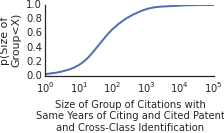

In [40]:
sns.set_style('white')

fig = figure(figsize=(fig_one_col, fig_one_col/1.618))

import powerlaw
x, y = powerlaw.cdf(group_sizes)
plot(x-1, y, linewidth=2)

xscale('log')
xlim(xmax=max(x))
legend(loc=4)

xlabel("Size of Group of Citations with\n"
       "Same Years of Citing and Cited Patent\n"
       "and Cross-Class Identification", fontsize=10)
ylabel("p(Size of\nGroup<X)")

fig.tight_layout()
sns.despine()

figures.append(fig)
if save_as_manuscript_figures:
    filename = 'Citation_Group_Sizes'
    savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')
#     savefig(figures_directory+filename+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'.eps', bbox_inches='tight')

In [41]:
x = 100*sum(group_sizes==1)/group_sizes.shape[0]
print("%.2f percent of year and cross-class pairings are unique (1 member in the group)."%x)

x = 100*sum(group_sizes<10)/group_sizes.shape[0]
print("%.2f percent of year and cross-class pairings have fewer than 10 members."%x)

2.55 percent of year and cross-class pairings are unique (1 member in the group).
14.16 percent of year and cross-class pairings have fewer than 10 members.


Number of Same-Class Links Erroneously Created
===

In [42]:
n_cross_class = sum(cross_class_ind)
n_same_class = sum(same_class_ind)
print("In the original network %.2f%% of citations are same-class"%
      (100*n_cross_class/(n_cross_class+n_same_class)))

In the original network 39.74% of citations are same-class


In [43]:
# patent_attributes = pd.read_csv(data_directory+'pid_issdate_ipc.csv')

# patent_attributes.ISSDATE = patent_attributes.ISSDATE.map(lambda x: int(x[-4:]))
# patent_attributes.rename(columns={
#                     'ISSDATE': 'Year',
#                     'IPC3': 'Class',
#                     'PID': 'Patent',
#                     },
#                  inplace=True)
# patent_attributes.set_index('Patent', inplace=True)

# citations_randomized = citations.copy()

# ### Take the same-class citations of every class and permute them.
# same_class_ind = citations_randomized['Same_Class']==True
# citations_randomized.ix[same_class_ind, 'Cited_Patent'] = citations_randomized.ix[same_class_ind].groupby(['Year_Citing_Patent', 
#     'Year_Cited_Patent', 
#     'Class_Citing_Patent', 
#     ])['Cited_Patent'].transform(permutation)

# ### Take the cross-class citations and permute them.
# cross_class_ind = -same_class_ind#citations_randomized['Same_Class']==False
# citations_randomized.ix[cross_class_ind, 'Cited_Patent'] = citations_randomized.ix[cross_class_ind].groupby(['Year_Citing_Patent', 
#     'Year_Cited_Patent', 
#     ])['Cited_Patent'].transform(permutation)

# ### Drop patent attributes (which are now inaccurate for the cited patent) and bring them in from patent_attributes
# citations_randomized = citations_randomized[['Citing_Patent', 'Cited_Patent', 'Same_Class']]

# citations_randomized = citations_randomized.merge(patent_attributes, 
#                 left_on='Citing_Patent', 
#                 right_index=True,
#                 )

# citations_randomized = citations_randomized.merge(patent_attributes, 
#                 left_on='Cited_Patent', 
#                 right_index=True,
#                 suffixes=('_Citing_Patent','_Cited_Patent'))

# n = sum((citations_randomized['Class_Citing_Patent']==citations_randomized['Class_Cited_Patent'] * -citations_randomized['Same_Class']))
# print("%.2f percent of the citations are now erroneously same-class when they should be cross-class"%(100*n/citations_randomized.shape[0]))

Empirical link values are typically very different from randomized controls
===

In [44]:
if class_system == 'IPC':
    controls = pd.read_hdf(data_directory+'class_relatedness_networks_controls_organized_IPC.h5',
                      'controls_%s'%class_system)
    controls = clean_measure_names(controls)

    controls_mean = controls.mean(axis=0)
    controls_std = controls.std(axis=0)

    drop_diagonal(controls_mean)
    drop_diagonal(controls_std)
    
    class_labels = pd.read_csv(data_directory+'class_labels_%s.csv'%class_system).set_index('Class')

    fig = figure(figsize=(fig_one_col, fig_one_col))#*1.618))
    sns.set_style("white")

    metric = 'Co-Citation'


    if class_system=='IPC':
        classes_visualized = ["A01", #Agriculture
                              "C07", #Organic Chemistry
                              "H03", #Electric Circuitry                                          
                              "G06", #Computing
                              "G02", #Optics
                              "B64", #Aircraft
                              "A41"] #Railways
    else:
        classes_visualized = empirical.major_axis[:7]
    n_classes_visualized = len(classes_visualized)
    for i in arange(n_classes_visualized):
        for j in arange(n_classes_visualized)[i:]:
            c = controls.ix[:,metric].ix[:,classes_visualized[i],classes_visualized[j]]

            if i==j:# and allclose(c, 1):
    #            plt.axis('off')
                continue
            else:
                ax = fig.add_subplot(n_classes_visualized,n_classes_visualized,
                                     (i*n_classes_visualized)+j)

                controls_hist = hist(c, color='lightgray')
            e = empirical.ix[metric].ix[classes_visualized[i],classes_visualized[j]]
            empirical_y_coords = (ylim()[0], ylim()[1]*.5)
            empirical_x_coors = (e,e)
            if e<c.min():
                empirical_color=sns.color_palette()[0] #'blue'
                empirical_line_below, = plot(empirical_x_coors, 
                                             empirical_y_coords, 
                                             color=empirical_color)
            elif e>c.max():
                empirical_color=sns.color_palette()[2] #'red'
                empirical_line_above, = plot(empirical_x_coors, 
                                             empirical_y_coords, 
                                             color=empirical_color)
            else:
                empirical_color=sns.color_palette()[1] #'green'
                empirical_line_within, = plot(empirical_x_coors, 
                                             empirical_y_coords, 
                                             color=empirical_color)
    #         empirical_line, = plot((e,e), (ylim()[0], ylim()[1]*.5), color=empirical_color)
            if i==0: #If we're in the first row, label the columns
                if class_labels is not None:
                    cl = class_labels.ix[classes_visualized[j], 'Class_label'].replace(" ", "\n")                            
                else:
                    cl = empirical.major_axis[j]
                ax.set_title(cl, fontsize=6)
            if i+1==j: #If we're at the edge of a row, label the row
                if class_labels is not None:
                    cl = class_labels.ix[classes_visualized[i], 'Class_label'].replace(" ", "\n")                            
                else:
                    cl = empirical.major_axis[i]

                ax.set_ylabel(cl, fontsize=6, labelpad=0)
    #            ax.yaxis.tick_right()
    #        plt.axis('off')
            sns.despine(left=True)
            ax.set_yticklabels([])
            ax.set_xticklabels([])

    fig.legend((controls_hist[-1][0],
                ), 
               ("Randomized\nControls' Values",
                ), 
               (.0,.3),
              fontsize=8)

    fig.text(.0, .29, 'Empirical Value:', fontsize=8)

    fig.legend((
                empirical_line_below, 
                empirical_line_within,
                empirical_line_above,
                ), 
               (
                'Below Random', 
               'Within Random',            
               'Above Random',            
                ), 
               (.0,.06),
              fontsize=8)

    # fig.subplots_adjust(hspace=0.4, 
    #                     wspace=0.4,
    #                    left=0,
    #                    right=.9,
    #                    bottom=0,
    #                    top=.9)
    fig.tight_layout(h_pad=0.4, w_pad=-.9,pad=0)
    figures.append(fig)
    if save_as_manuscript_figures:
        filename = 'Rewiring_Histogram'
        savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')
        # savefig(figures_directory+filename+'.svg', bbox_inches='tight')
        # savefig(figures_directory+filename+'.eps', bbox_inches='tight')

OSError: File ../data/class_relatedness_networks_controls_organized_IPC.h5 does not exist

Most links are weak, some links are strong
====
~70% of links are weaker than would be expected by chance, while the remaining ~20% of links are stronger than expected by chance. Thus, the connectivity network is a sparse network.

In [47]:
store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/class_relatedness_networks.h5')

In [63]:
controls_max = clean_measure_names(store['randomized_max_%s'%class_system].ix[:,target_year])
controls_min = clean_measure_names(store['randomized_min_%s'%class_system].ix[:,target_year])

In [66]:
summary_table = pd.DataFrame(index=empirical.items,
                            columns=["Below Randomized Controls",
                                     "Within Randomized Controls",
                                     "Above Randomized Controls"
                                     ]
                            )

for metric in empirical.items:
    n_links = product(empirical.ix[metric].shape)-empirical.ix[metric].shape[0]
    above_random = 100*sum(off_diagonal(empirical.ix[metric].values>controls_max.ix[metric].values))/n_links
    below_random = 100*sum(off_diagonal(empirical.ix[metric].values<controls_min.ix[metric].values))/n_links
    within_random = 100-above_random-below_random
    summary_table.ix[metric, "Above Randomized Controls"] = above_random
    summary_table.ix[metric, "Below Randomized Controls"] = below_random
    summary_table.ix[metric, "Within Randomized Controls"] = within_random

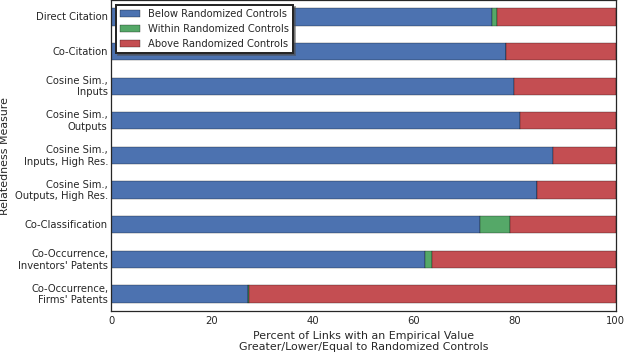

In [67]:
fig = figure(figsize=(fig_two_col, fig_two_col/1.618))
ax = fig.add_subplot(1,1,1)

summary_table.iloc[::-1].plot(kind='barh', 
                                        stacked=True, 
                                        legend=False,
                                       ax=ax)
#xlim(xmax=100)

xlabel("Percent of Links with an Empirical Value\n"
       "Greater/Lower/Equal to Randomized Controls")
ylabel("Relatedness Measure")


#pretty_tick_labels(wraplength=20, axis='y')
l = legend(loc="upper left",
       frameon=True,
       shadow=True)
fr = l.get_frame() 
fr.set_linewidth(2)

# figures.append(fig)

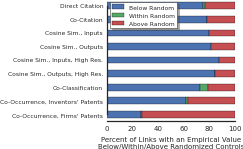

In [68]:
fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

summary_table.rename(columns={'Below Randomized Controls': 'Below Random',
                              'Within Randomized Controls': 'Within Random',
                              'Above Randomized Controls': 'Above Random'
                             }).iloc[::-1].plot(kind='barh', 
                                        stacked=True, 
                                        legend=False,
                                       ax=ax)
#xlim(xmax=100)

ax.set_yticklabels([x.get_text().replace('\n', ' ') for x in ax.get_yticklabels()],
                  fontsize=6)
#                   rotation=90, ha='center')
xticks(fontsize=7)

xlabel("Percent of Links with an Empirical Value\n"
       "Below/Within/Above Randomized Controls", fontsize=7)
#ylabel("Relatedness Measure", fontsize=8)
ylabel("")


#pretty_tick_labels(wraplength=20, axis='y')
l = legend(loc="upper left",
       frameon=True,
       shadow=True,
          fontsize=6)
fr = l.get_frame() 
fr.set_linewidth(.5)

sns.despine(trim=True)

fig.tight_layout(pad=0)
fig.subplots_adjust(bottom=.2, top=1,left=.43,right=.95, wspace=None, hspace=None, )

# figures.append(fig)
if save_as_manuscript_figures:
    filename = 'Related_Unrelated_Percentages'
    savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')

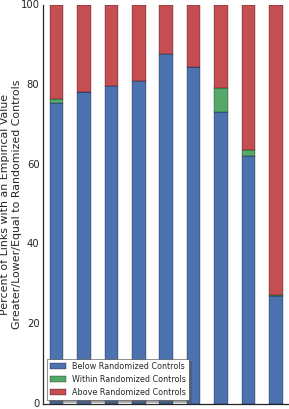

In [69]:
fig = figure(figsize=(fig_one_col, fig_one_col*1.618))
ax = fig.add_subplot(1,1,1)
ax.xaxis.tick_top()

summary_table.plot(kind='bar',
                   stacked=True, 
                   legend=False,
                   ax=ax)
ylim(ymax=100)
sns.despine()

ylabel("Percent of Links with an Empirical Value\n"
       "Greater/Lower/Equal to Randomized Controls",labelpad=0)
xlabel("Relatedness Measure",labelpad=0)
xlabel("",labelpad=0)


ax.set_xticklabels([x.get_text().replace('\n', ' ') for x in ax.get_xticklabels()],
                  rotation=90, ha='center')

#pretty_tick_labels(wraplength=20, axis='y')
l = legend(loc="lower left",
       frameon=True,
       shadow=True,
          fontsize=8)
fr = l.get_frame() 
fr.set_linewidth(.5)

figures.append(fig)

In [78]:
n_positive_links = (empirical>controls_max).sum(axis=1)
print(n_positive_links.min())
for measure in n_positive_links.columns:
    if any(n_positive_links[measure]==0):
        i = where(n_positive_links[measure]==0)[0]
        print('\n'+measure.replace("\n", " "))
        print(class_labels.ix[empirical.major_axis[i], 'Class_label'])

New_Name
Direct Citation                        3
Co-Citation                            6
Cosine Sim.,\nInputs                   3
Cosine Sim.,\nOutputs                  5
Cosine Sim.,\nInputs, High Res.        5
Cosine Sim.,\nOutputs, High Res.       4
Co-Classification                      2
Co-Occurrence,\nInventors' Patents    13
Co-Occurrence,\nFirms' Patents        10
dtype: int64


In [15]:
z_scores = clean_measure_names(pd.read_hdf(data_directory+'Class_Relatedness_Networks/class_relatedness_networks.h5',
                  'empirical_z_scores_%s'%class_system).ix[:,target_year])

In [76]:
if class_system == 'IPC':
    from scipy.stats import scoreatpercentile
    high_empirical = scoreatpercentile(off_diagonal(empirical['Direct Citation']), 99)
    low_normalized = scoreatpercentile(off_diagonal(z_scores['Direct Citation']), 1)
    xs, ys = where(((empirical['Direct Citation']>=high_empirical) * 
                        (z_scores['Direct Citation']<=low_normalized)).values)
    for x, y in zip(xs, ys):
        print("From %s to %s"%(class_labels.ix[empirical.major_axis[x], 'Class_label'], 
              class_labels.ix[empirical.major_axis[y], 'Class_label'])) 
        print("Citations: %i, Controls mean: %.2f, Controls std: %.2f: Z-Score: %.2f"%(empirical['Direct Citation'].iloc[x,y],
                                              controls_mean['Direct Citation'].iloc[x,y],
                                              controls_std['Direct Citation'].iloc[x,y],
                                             z_scores['Direct Citation'].iloc[x,y]))

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


NameError: name 'class_labels' is not defined

In [ ]:
# for item in z_scores.items:
#     z_scores.ix[item].to_csv(item.replace('\n', ' ')+'_z_scores.csv')

In [79]:
summary_table = pd.DataFrame(index=z_scores.items,
                            columns=["Below Random Expectation",
                                     "Exactly Equal to Random Expectation",
                                     "Above Random Expectation",
                                     ]
                            )

for measure in z_scores.items:
    vals = off_diagonal(z_scores.ix[measure].fillna(0).values)
    summary_table.ix[measure, "Above Random Expectation"] = 100*(sum(vals>0)/len(vals))
    summary_table.ix[measure, "Below Random Expectation"] = 100*(sum(vals<0)/len(vals))
    summary_table.ix[measure, "Exactly Equal to Random Expectation"] = 100*(sum(vals==0)/len(vals))

In [80]:
summary_table

,Below Random Expectation,Exactly Equal to Random Expectation,Above Random Expectation
New_Name,,,
Direct Citation,74.53168,0.7644628,24.70386
Co-Citation,77.7686,0.05509642,22.17631
"Cosine Sim.,\nInputs",79.42149,0,20.57851
"Cosine Sim.,\nOutputs",80.70248,0,19.29752
"Cosine Sim.,\nInputs, High Res.",87.09366,0,12.90634
"Cosine Sim.,\nOutputs, High Res.",83.71901,0.05509642,16.2259
Co-Classification,71.40496,5.633609,22.96143
"Co-Occurrence,\nInventors' Patents",59.51791,0.7713499,39.71074
"Co-Occurrence,\nFirms' Patents",25,0.2066116,74.79339


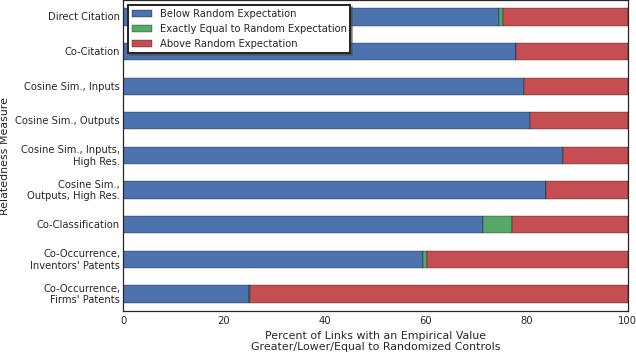

In [81]:
fig = figure(figsize=(fig_two_col, fig_two_col/1.618))
ax = fig.add_subplot(1,1,1)

summary_table.iloc[::-1].plot(kind='barh', 
                                        stacked=True, 
                                        legend=False,
                                       ax=ax)
xlim(xmax=100)

xlabel("Percent of Links with an Empirical Value\n"
       "Greater/Lower/Equal to Randomized Controls")
ylabel("Relatedness Measure")


pretty_tick_labels(wraplength=20, axis='y')
l = legend(loc="upper left",
       frameon=True,
       shadow=True)
fr = l.get_frame() 
fr.set_linewidth(2)

Co-Occurrence data that preserves year-by-year class and entity counts, vs. not
===

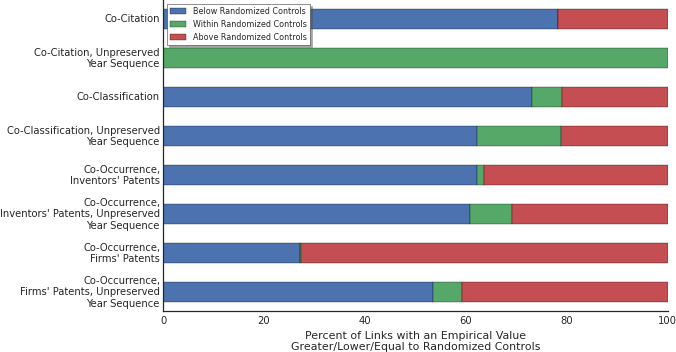

In [97]:
if class_system =='IPC':
    unpreserved_years_controls_store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/cooccurrence/class_relatedness_networks_cooccurrence_no_preserve_years.h5')

    unpreserved_years_controls_max = clean_measure_names(unpreserved_years_controls_store['randomized_max_%s'%class_system].ix[:,target_year])
    unpreserved_years_controls_min = clean_measure_names(unpreserved_years_controls_store['randomized_min_%s'%class_system].ix[:,target_year])

    drop_diagonal(unpreserved_years_controls_max)
    drop_diagonal(unpreserved_years_controls_min)

    summary_table = pd.DataFrame(columns=["Below Randomized Controls",
                                         "Within Randomized Controls",
                                         "Above Randomized Controls"
                                         ]
                                )

    for metric in unpreserved_years_controls_max.items:
        if 'Co-' not in metric:
            continue
        n_links = product(empirical.ix[metric].shape)-empirical.ix[metric].shape[0]

        above_random = 100*sum(off_diagonal(empirical.ix[metric].values>controls_max.ix[metric].values))/n_links
        below_random = 100*sum(off_diagonal(empirical.ix[metric].values<controls_min.ix[metric].values))/n_links
        within_random = 100-above_random-below_random

        summary_table.ix[metric, "Above Randomized Controls"] = above_random
        summary_table.ix[metric, "Below Randomized Controls"] = below_random
        summary_table.ix[metric, "Within Randomized Controls"] = within_random

        above_random = 100*sum(off_diagonal(empirical.ix[metric].values>unpreserved_years_controls_max.ix[metric].values))/n_links
        below_random = 100*sum(off_diagonal(empirical.ix[metric].values<unpreserved_years_controls_min.ix[metric].values))/n_links
        within_random = 100-above_random-below_random

        summary_table.ix[metric+', Unpreserved\nYear Sequence', "Above Randomized Controls"] = above_random
        summary_table.ix[metric+', Unpreserved\nYear Sequence', "Below Randomized Controls"] = below_random
        summary_table.ix[metric+', Unpreserved\nYear Sequence', "Within Randomized Controls"] = within_random

        summary_table

    fig = figure(figsize=(fig_two_col, fig_two_col/1.618))
    ax = fig.add_subplot(1,1,1)

    summary_table.iloc[::-1].plot(kind='barh', 
                                            stacked=True, 
                                            legend=False,
                                           ax=ax)

    xlabel("Percent of Links with an Empirical Value\n"
           "Greater/Lower/Equal to Randomized Controls")
    ylabel("")


    #pretty_tick_labels(wraplength=20, axis='y')
    l = legend(loc="upper left",
           frameon=True,
           shadow=True,
              fontsize=8)
    fr = l.get_frame() 
    fr.set_linewidth(.5)

    sns.despine()

    figures.append(fig)

    if save_as_manuscript_figures:
        filename = 'CoOccurrence_Year_Preservation_Comparison'
        savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')

Correlation of relatedness measures with popularity and each other, before and after normalizing
===

In [16]:
from scipy.stats import pearsonr, spearmanr

def _remove_leading_zero(value, string):
    if 1 > value > -1:
        string = string.replace('0', '', 1)
    return string


class MyFloat(float):
    def __str__(self):
        string = super().__str__()
        return _remove_leading_zero(self, string)

    def __format__(self, format_string):
        string = super().__format__(format_string)
        return _remove_leading_zero(self, string)

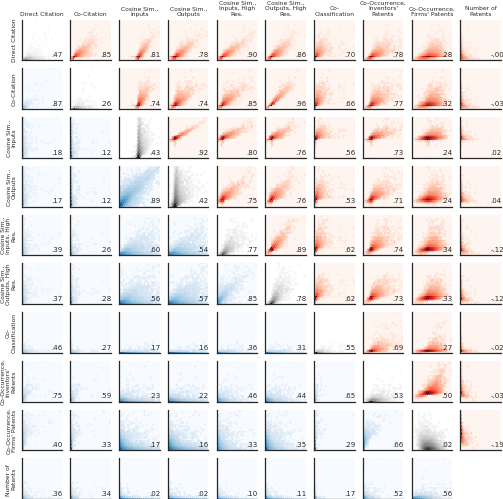

In [34]:
sns.set_style("white")

fig = figure(figsize=(fig_two_col, fig_two_col))

link_types = empirical.items.values.tolist()+['Number of Patents']

nrows = len(link_types)
ncols = len(link_types)
this_ax = 0

s = 1
this_fontsize = 6
from textwrap import wrap
for i in range(len(link_types)):
    for j in range(len(link_types)):

        this_ax += 1

        ax = fig.add_subplot(nrows, ncols, this_ax)
        if i==0:
            ax.set_title(link_types[j], fontsize=this_fontsize)
        if j==0:
            ax.set_ylabel(link_types[i], fontsize=this_fontsize)
        
        if i<j:
            normalized=True
            color='Reds'#'red'
        elif i>j:
            normalized=False
            color='Blues'#'blue'
        if i==j:
            try:
                vals_i = off_diagonal(empirical.iloc[i].fillna(0).values)
                vals_j = off_diagonal(z_scores.iloc[j].fillna(0).values)
            except IndexError:
                ax.set_frame_on(False)
                ax.set_yticks([])
                ax.set_xticks([])
                continue
            color='Greys'
        else:
            try:
                if normalized:
                    vals_i = off_diagonal(z_scores.iloc[i].fillna(0).values)
                else:
                    vals_i = off_diagonal(empirical.iloc[i].fillna(0).values)
            except IndexError:        
                if i==ncols-1:
                    vals_i = off_diagonal(patent_count_links)
            try:
                if normalized:
                    vals_j = off_diagonal(z_scores.iloc[j].fillna(0).values)
                else:
                    vals_j = off_diagonal(empirical.iloc[j].fillna(0).values)
            except IndexError:        
                if j==ncols-1:
                    vals_j = off_diagonal(patent_count_links)
        ax.hexbin(vals_j, vals_i, bins='log', gridsize=20, cmap=color)#, color=color, gridsize=10)#, s=s)
#           ax.scatter(vals_j, vals_i, color=color, s=s)

        
        ax.text(0.75,.1,
                '{:.2f}'.format(MyFloat(pearsonr(vals_j,vals_i)[0])),
                transform=ax.transAxes, fontsize=7)
#         ax.set_yscale('symlog')
#         ax.set_xscale('symlog')        
        sns.despine()
        ax.set_yticks([])
        ax.set_xticks([])
        pretty_axis_labels(wraplength=15, fontsize=this_fontsize)
        pretty_titles(wraplength=15, fontsize=this_fontsize)

fig.subplots_adjust(top=.95, left=.05)
figures.append(fig)
if save_as_manuscript_figures:
    filename = 'Measure_Comparison_Hex_Plots'
    savefig(figures_directory+filename+'_'+class_system+'.png', dpi=440)#, bbox_inches='tight')

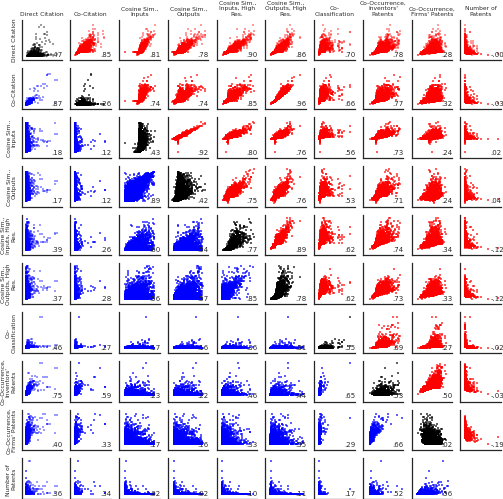

In [35]:
sns.set_style("white")

fig = figure(figsize=(fig_two_col, fig_two_col))

link_types = empirical.items.values.tolist()+['Number of Patents']

nrows = len(link_types)
ncols = len(link_types)
this_ax = 0

s = 1
this_fontsize = 6
from textwrap import wrap
for i in range(len(link_types)):
    for j in range(len(link_types)):

        this_ax += 1

        ax = fig.add_subplot(nrows, ncols, this_ax)
        if i==0:
            ax.set_title(link_types[j], fontsize=this_fontsize)
        if j==0:
            ax.set_ylabel(link_types[i], fontsize=this_fontsize)
        
        if i<j:
            normalized=True
            color='red'
        elif i>j:
            normalized=False
            color='blue'
        if i==j:
            try:
                vals_i = off_diagonal(empirical.iloc[i].fillna(0).values)
                vals_j = off_diagonal(z_scores.iloc[j].fillna(0).values)
            except IndexError:
                ax.set_frame_on(False)
                ax.set_yticks([])
                ax.set_xticks([])
                continue
            color='black'
        else:
            try:
                if normalized:
                    vals_i = off_diagonal(z_scores.iloc[i].fillna(0).values)
                else:
                    vals_i = off_diagonal(empirical.iloc[i].fillna(0).values)
            except IndexError:        
                if i==ncols-1:
                    vals_i = off_diagonal(patent_count_links)
            try:
                if normalized:
                    vals_j = off_diagonal(z_scores.iloc[j].fillna(0).values)
                else:
                    vals_j = off_diagonal(empirical.iloc[j].fillna(0).values)
            except IndexError:        
                if j==ncols-1:
                    vals_j = off_diagonal(patent_count_links)
#         ax.hexbin(vals_j, vals_i, bins='log', gridsize=20, cmap=color)#, color=color, gridsize=10)#, s=s)
        ax.scatter(vals_j, vals_i, color=color, s=s)

        
        ax.text(0.75,.1,
                '{:.2f}'.format(MyFloat(pearsonr(vals_j,vals_i)[0])),
                transform=ax.transAxes, fontsize=7)
#         ax.set_yscale('symlog')
#         ax.set_xscale('symlog')        
        sns.despine()
        ax.set_yticks([])
        ax.set_xticks([])
        pretty_axis_labels(wraplength=15, fontsize=this_fontsize)
        pretty_titles(wraplength=15, fontsize=this_fontsize)

fig.subplots_adjust(top=.95, left=.05)
figures.append(fig)
if save_as_manuscript_figures:
    filename = 'Measure_Comparison_Scatter_Plots'
    savefig(figures_directory+filename+'_'+class_system+'.png', dpi=440)#, bbox_inches='tight')

In [37]:
def correlate_measures(networks,
                      correlation=pearsonr,
                      use_absolute=True,
                      link_types=None):
    if link_types is None:        
        link_types = networks.items.values.tolist()+['Number of Patents']#['Number of Citing Patents', 'Number of Cited Patents']
        #link_types = [link for link in link_types if 'Jaccard' not in link]


    data_correlations = pd.DataFrame(index=link_types,
                                     columns=link_types)

    comparisons_to_make = []
    for i in range(len(link_types)):
        for j in range((i+1),len(link_types)):
            comparisons_to_make.append((link_types[i], link_types[j]))

    def g(X):
        values_to_correlate = []
        for x in X:
            if x=='Number of Citing Patents':
                vals = citing_patent_count_links
            elif x=='Number of Cited Patents':
                vals = cited_patent_count_links
            elif x=='Number of Patents':
                vals = patent_count_links

            else:
                vals = networks.ix[x].fillna(0).values
            vals = off_diagonal(vals)
            values_to_correlate.append(vals)
        return correlation(values_to_correlate[0], values_to_correlate[1])[0]

    correlations = list(map(g, comparisons_to_make))

    for i in range(len(correlations)):
        data_correlations.ix[comparisons_to_make[i]] = correlations[i]
        data_correlations.ix[comparisons_to_make[i][::-1]] = correlations[i]

    data_correlations = data_correlations.astype('float')
#     data_correlations.index = [x.replace("\n"," ") for x in data_correlations.index]
#     data_correlations.columns = [x.replace("\n"," ") for x in data_correlations.columns]

    if use_absolute:
        data_correlations = abs(data_correlations)
    return data_correlations

In [38]:
correlations_empirical = correlate_measures(empirical)
correlations_z_scores = correlate_measures(z_scores)
correlations_empirical_ranked = correlate_measures(empirical,correlation=spearmanr)
correlations_z_scores_ranked = correlate_measures(z_scores,correlation=spearmanr)

In [39]:
print("Correlation of direct citations in both directions for\n"
      "Empirical: %.2f\n"
      "Normalized: %.2f"%(pearsonr(off_diagonal(empirical['Direct Citation'].values),
                                   off_diagonal(empirical['Direct Citation'].values.T),
                                  )[0],
                          pearsonr(off_diagonal(z_scores['Direct Citation'].fillna(0).values),
                                   off_diagonal(z_scores['Direct Citation'].fillna(0).values.T),
                                  )[0]
                          )
      )

Correlation of direct citations in both directions for
Empirical: 0.87
Normalized: 0.92


In [40]:
from matplotlib.colors import LogNorm, Normalize

def plot_correlations(data_correlations, ax,
                      show_x=True,
                      show_y=True,
                      norm=Normalize,
                      vmin=0.0,
                      vmax=1.0,
                     use_absolute=True):       

    labels = [x.replace("\n"," ") for x in data_correlations.index]
#    data_correlations.columns = [x.replace("\n"," ") for x in data_correlations.columns]

    if use_absolute:
        data_correlations = abs(data_correlations)
    im = ax.imshow(data_correlations,
                   'hot', 
                   interpolation='nearest',
                   norm=norm(vmin=vmin, vmax=vmax),
                  )

    #ax.xaxis.tick_top()

    f = lambda x: x.replace("_", " ").replace("\n"," ")[:45]
    _ = xticks(range(len(labels)), list(map(f, labels)), rotation=90, ha='center')
    _ = yticks(range(len(labels)), list(map(f, labels)))
    
    if not show_y:
        ax.set_yticklabels([])
    if not show_x:
        ax.set_xticklabels([])
    return im

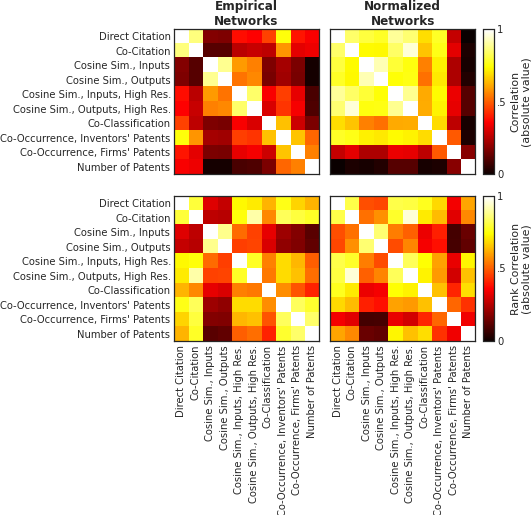

In [41]:
sns.set_style("white")

fig = figure(figsize=(fig_two_col, fig_two_col/1.618))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

nrows = 2
ncols = 2
    
ax1 = fig.add_subplot(nrows, ncols,1)
im_empirical = plot_correlations(correlations_empirical,
                                                ax1,
                                                norm=Normalize,
                                                show_x=False,
                                                show_y=True,
                                               )


ax2 = fig.add_subplot(nrows, ncols,2)
im_empirical_z_scores = plot_correlations(correlations_z_scores,
                                                ax2,
                                                norm=Normalize,
                                                show_x=False,
                                                show_y=False,
                                               )


ax3 = fig.add_subplot(nrows, ncols,3)
im_empirical_ranked = plot_correlations(correlations_empirical_ranked,
                                                ax3,
                                                norm=Normalize,
                                                show_x=True,
                                                show_y=True,
                                               )


ax4 = fig.add_subplot(nrows, ncols,4)
im_empirical_z_scores_ranked = plot_correlations(correlations_z_scores_ranked,
                                                ax4,
                                                norm=Normalize,
                                                show_x=True,
                                                show_y=False,
                                               )


fig.subplots_adjust(hspace=.15, wspace=-.55)

ax1.set_title('Empirical\nNetworks', weight='bold')
ax2.set_title('Normalized\nNetworks', weight='bold')


axins = inset_axes(ax2,
                   width="8%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=3,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )

cbar = colorbar(im_empirical_z_scores,
                cax=axins,
                orientation='vertical',
                label="Correlation\n(absolute value)",
               ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", ".5", "1"])

# ax3.set_xlabel('Empirical Networks', weight='bold')
# ax4.set_xlabel('Normalized Networks', weight='bold')

axins = inset_axes(ax4,
                   width="8%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=3,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax4.transAxes,
                   borderpad=0,
                   )

cbar = colorbar(im_empirical_z_scores_ranked,
             cax=axins,
             orientation='vertical',
             label="Rank Correlation\n(absolute value)",
               ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", ".5", "1"])

#fig.tight_layout()
figures.append(fig)

# if save_as_manuscript_figures:
#     filename = 'Network_Correlations'
#     savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.eps', bbox_inches='tight')

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


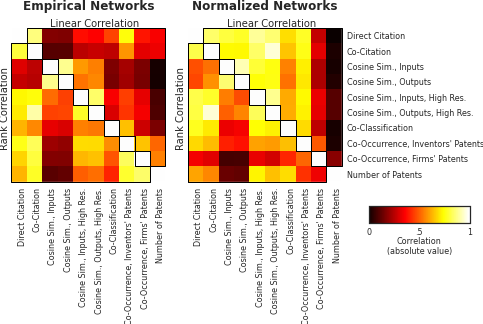

In [42]:
sns.set_style("white")

fig = figure(figsize=(fig_two_col, fig_two_col/1.5))#618))

nrows = 1
ncols = 2
    
ax = fig.add_subplot(nrows, ncols,1)


A = abs(correlations_empirical)
N = A.shape[0]

mask =  tri(A.shape[0], k=-1)
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'hot', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

A = abs(correlations_empirical_ranked)
mask =  tri(A.shape[0], k=-1).T
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'hot', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

import matplotlib.patches as patches
line = ([(0, N - 1), (0, 0), (N - 1, 0)] +
        [(N - 1 - i - j, i + 1) for i in range(N - 1) for j in (0, 1)])
lines = [line, [(N - x, N - y) for x, y in line]]
for line in lines:
    path = patches.Polygon(line, facecolor='none', edgecolor='black',
                           linewidth=1, closed=True, joinstyle='round')
    ax.add_patch(path)


ylabel('Rank Correlation', fontsize=10, labelpad=0, y=.48)
xlabel('Linear Correlation', fontsize=10, labelpad=1, x=.54)
ax.xaxis.set_label_position("top")

ax.set_title('Empirical Networks', fontsize=12,y=1.08, weight='bold')

margin = 0.09
ax.set_xlim(-margin, N + margin)
ax.set_ylim(-margin, N + margin)
sns.despine(left=True, bottom=True, right=True)


ax.yaxis.tick_right()
f = lambda x: x.replace("_", " ").replace("\n", " ")

labels = empirical.items.values.tolist()+['Number of Patents']

_ = xticks(.7+arange(shape(labels)[0]), list(map(f, labels)), rotation=90, ha='center', fontsize=8)

yticks([])


ax = fig.add_subplot(nrows, ncols,2)

A = abs(correlations_z_scores)
N = A.shape[0]

mask =  tri(A.shape[0], k=-1)
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'hot', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

A = abs(correlations_z_scores_ranked)
mask =  tri(A.shape[0], k=-1).T
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'hot', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

import matplotlib.patches as patches
line = ([(0, N - 1), (0, 0), (N - 1, 0)] +
        [(N - 1 - i - j, i + 1) for i in range(10 - 1) for j in (0, 1)])
lines = [line, [(N - x, N - y) for x, y in line]]
for line in lines:
    path = patches.Polygon(line, facecolor='none', edgecolor='black',
                           linewidth=1, closed=True, joinstyle='round')
    ax.add_patch(path)


ylabel('Rank Correlation', fontsize=10, labelpad=0, y=.48)
xlabel('Linear Correlation', fontsize=10, labelpad=1, x=.54)
ax.xaxis.set_label_position("top")

ax.set_title('Normalized Networks', fontsize=12,y=1.08, weight='bold')

margin = 0.09
ax.set_xlim(-margin, N + margin)
ax.set_ylim(-margin, N + margin)
sns.despine(left=True, bottom=True, right=True)


ax.yaxis.tick_right()
f = lambda x: x.replace("_", " ").replace("\n", " ")

labels = empirical.items.values.tolist()+['Number of Patents']

_ = xticks(.7+arange(shape(labels)[0]), list(map(f, labels)), rotation=90, ha='center', fontsize=8)
_ = yticks(.5+arange(shape(labels)[0]), list(map(f, labels))[::-1], va='center', fontsize=8)


ax2 = fig.add_axes([.75, 0.3, 0.2, 0.05])
norm = Normalize(vmin=0, vmax=1)

# ax2 = inset_axes(ax,
#                 width="70%", # width = 10% of parent_bbox width
#                 height="10%", # height : 50%
#                 loc=1,
#                 bbox_to_anchor=(.02, .02, 1, 1),
#                bbox_transform=ax.transAxes,
#                borderpad=0,
#                    )

cbar = mpl.colorbar.ColorbarBase(ax2, 
                                 cmap=cm.hot,
                                 norm=norm,
                                 orientation='horizontal',
                                 label='Correlation\n(absolute value)',
                                ticks=[0, 0.5, 1])

cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel('Correlation\n(absolute value)', fontsize=8, labelpad=0)
cbar.ax.set_xticklabels(["0", ".5", "1"])
# figures.append(fig)
fig.tight_layout()
fig.subplots_adjust(bottom=.3, wspace=None, top=1, hspace=None, left=None, right=None)




# if save_as_manuscript_figures:
#     filename = 'Network_Correlations_Combined'
#     savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.eps', bbox_inches='tight')

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


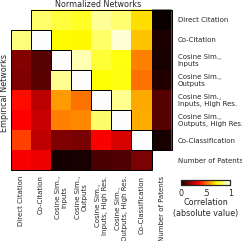

In [43]:
sns.set_style("white")

fig = figure(figsize=(fig_one_col, fig_one_col))#*1.618))

nrows = 1
ncols = 1

metrics_for_matrix = ['Direct Citation', 
                      'Co-Citation',                     
                      'Cosine Sim.,\nInputs',
                      'Cosine Sim.,\nOutputs',
                      'Cosine Sim.,\nInputs, High Res.',
                      'Cosine Sim.,\nOutputs, High Res.',
                      'Co-Classification',                        
                      'Number of Patents']

ax = fig.add_subplot(nrows, ncols,1)


A = abs(correlations_z_scores.ix[metrics_for_matrix][metrics_for_matrix])
N = A.shape[0]

mask =  tri(A.shape[0], k=-1)
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'hot', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

A = abs(correlations_empirical.ix[metrics_for_matrix][metrics_for_matrix])
mask =  tri(A.shape[0], k=-1).T
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'hot', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

import matplotlib.patches as patches
line = ([(0, N - 1), (0, 0), (N - 1, 0)] +
        [(N - 1 - i - j, i + 1) for i in range(N - 1) for j in (0, 1)])
lines = [line, [(N - x, N - y) for x, y in line]]
for line in lines:
    path = patches.Polygon(line, facecolor='none', edgecolor='black',
                           linewidth=1, closed=True, joinstyle='round')
    ax.add_patch(path)


ylabel('Empirical Networks', fontsize=8, labelpad=0, y=.48)
xlabel('Normalized Networks', fontsize=8, labelpad=1, x=.54)
ax.xaxis.set_label_position("top")

# ax.set_title('Empirical Networks', fontsize=12,y=1.08, weight='bold')

margin = 0.09
ax.set_xlim(-margin, N + margin)
ax.set_ylim(-margin, N + margin)
sns.despine(left=True, bottom=True, right=True)


ax.yaxis.tick_right()
f = lambda x: x.replace("_", " ")#.replace("\n", " ")

labels = metrics_for_matrix
_ = xticks(.5+arange(shape(labels)[0]), list(map(f, labels)), rotation=90, ha='center', fontsize=7)
_ = yticks(.5+arange(shape(labels)[0]), list(map(f, labels))[::-1], va='center', fontsize=7)


ax2 = fig.add_axes([.73, 0.25, 0.2, 0.02])
norm = Normalize(vmin=0, vmax=1)

cbar = mpl.colorbar.ColorbarBase(ax2, 
                                 cmap=cm.hot,
                                 norm=norm,
                                 orientation='horizontal',
                                 label='Correlation\n(absolute value)',
                                ticks=[0, 0.5, 1])

cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel('Correlation\n(absolute value)', fontsize=8, labelpad=0)
cbar.ax.set_xticklabels(["0", ".5", "1"])






fig.tight_layout(pad=0)
fig.subplots_adjust(bottom=.3, top=.97, wspace=None, hspace=None, left=None, right=.7)
figures.append(fig)


if save_as_manuscript_figures:
    filename = 'Network_Correlations_Linear'
    savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')

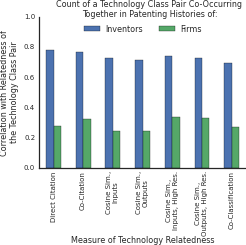

In [45]:
sns.set_style("white")

fig = figure(figsize=(fig_one_col, fig_one_col))#*1.618))

nrows = 1
ncols = 1
    
ax = fig.add_subplot(nrows, ncols,1)

measures_to_compare = ['Direct Citation', 
                      'Co-Citation',                       
                      'Cosine Sim.,\nInputs',
                      'Cosine Sim.,\nOutputs',
                      'Cosine Sim.,\nInputs, High Res.',
                      'Cosine Sim.,\nOutputs, High Res.',
                      'Co-Classification',                       
                       ]
data = correlations_z_scores.ix[["Co-Occurrence,\nInventors' Patents",
                          "Co-Occurrence,\nFirms' Patents"]][measures_to_compare].T
data = data.rename(columns={"Co-Occurrence,\nInventors' Patents": "Inventors",
                    "Co-Occurrence,\nFirms' Patents": "Firms"})

# def r_CI95(r, n_classes=121, directed=False):
#     N = n_classes*(n_classes-1)
#     if not directed:
#         N /= 2
#     SE = 1/sqrt(N-3)
#     CI95 = 1.96*SE
#     z_prime = arctanh(r)
#     z_prime_lower, z_prime_upper = z_prime-CI95, z_prime+CI95
#     r_lower, r_upper = tanh(z_prime_lower), tanh(z_prime_upper)
#     return (r_upper-r_lower)/2

# errs = data.applymap(r_CI95)
# errs.ix['Direct Citation'] = data.ix['Direct Citation'].map(lambda x: r_CI95(x,directed=True))
# errs = hstack([zeros((errs.shape[1],1,errs.shape[0])),
#         (errs).values.reshape([errs.shape[1],1,errs.shape[0]])
#         ])

data.plot(kind='bar',
#           yerr=errs,
          ax=ax, 
          legend=False,
          fontsize=7)

ax.set_xlabel("Measure of Technology Relatedness",fontsize=8, labelpad=0)
ax.set_ylabel("Correlation with Relatedness of\nthe Technology Class Pair",
#               "& their Co-Occurrence in Behavioral Data",
              fontsize=8)
#Correlation of the Normalized Relatedness between Technology Classes & their Co-Occurrence in Behavioral Data
ax.set_ylim(0,1)
sns.despine(ax=ax)

# bbox_to_anchor=(0., 1, 1., 0.08),     
l = legend(loc="upper center", ncol=2, fontsize=8)
# l = legend(bbox_to_anchor=(0., 1, 1., 0.15), loc="upper center", ncol=2, fontsize=8)
# renderer = fig.canvas.get_renderer()
# shift = max([t.get_window_extent(renderer).width for t in l.get_texts()])
# for t in l.get_texts():
#     t.set_ha('center') # ha is alias for horizontalalignment
#     t.set_position((shift*.45,0))

fig.text(.6, .92, 'Count of a Technology Class Pair Co-Occurring\nTogether in Patenting Histories of:',
        fontsize=8, ha='center')
# title('Count of a Technology Class Pair Co-Occurring\nin Patenting Histories of:', fontsize=8)
fig.tight_layout(pad=0.1)
# fig.subplots_adjust(bottom=.24, wspace=None, top=.98, hspace=None, left=None, right=None)
fig.subplots_adjust(bottom=.31, wspace=None, top=.92, hspace=None, left=None, right=None)
figures.append(fig)
if save_as_manuscript_figures:
    filename = 'Relatedness_Behavior_Correlation'
    savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.eps', bbox_inches='tight')

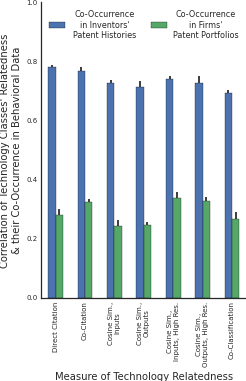

In [46]:
sns.set_style("white")

fig = figure(figsize=(fig_one_col, fig_one_col*1.618))

nrows = 1
ncols = 1
    
ax = fig.add_subplot(nrows, ncols,1)

measures_to_compare = ['Direct Citation', 
                      'Co-Citation',                       
                      'Cosine Sim.,\nInputs',
                      'Cosine Sim.,\nOutputs',
                      'Cosine Sim.,\nInputs, High Res.',
                      'Cosine Sim.,\nOutputs, High Res.',
                      'Co-Classification',                       
                       ]
data = correlations_z_scores.ix[["Co-Occurrence,\nInventors' Patents",
                          "Co-Occurrence,\nFirms' Patents"]][measures_to_compare].T
data = data.rename(columns={"Co-Occurrence,\nInventors' Patents": "Co-Occurrence\nin Inventors'\nPatent Histories",
                    "Co-Occurrence,\nFirms' Patents": "Co-Occurrence\nin Firms'\nPatent Portfolios"})

def r_CI95(r, n_classes=121, directed=False):
    N = n_classes*(n_classes-1)
    if not directed:
        N /= 2
    SE = 1/sqrt(N-3)
    CI95 = 1.96*SE
    z_prime = arctanh(r)
    z_prime_lower, z_prime_upper = z_prime-CI95, z_prime+CI95
    r_lower, r_upper = tanh(z_prime_lower), tanh(z_prime_upper)
    return (r_upper-r_lower)/2

errs = data.applymap(r_CI95)
errs.ix['Direct Citation'] = data.ix['Direct Citation'].map(lambda x: r_CI95(x,directed=True))
errs = hstack([zeros((errs.shape[1],1,errs.shape[0])),
        (errs).values.reshape([errs.shape[1],1,errs.shape[0]])
        ])

data.plot(kind='bar',
          yerr=errs,
          ax=ax, 
          legend=False,
          fontsize=7)

ax.set_xlabel("Measure of Technology Relatedness",fontsize=10)
ax.set_ylabel("Correlation of Technology Classes' Relatedness\n"
              "& their Co-Occurrence in Behavioral Data",
              fontsize=10)
#Correlation of the Normalized Relatedness between Technology Classes & their Co-Occurrence in Behavioral Data
ax.set_ylim(0,1)
sns.despine(ax=ax)

# bbox_to_anchor=(0., 1, 1., 0.08),     
l = legend(loc="upper center", ncol=2, fontsize=8)
renderer = fig.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in l.get_texts()])
for t in l.get_texts():
    t.set_ha('center') # ha is alias for horizontalalignment
    t.set_position((shift*.45,0))

fig.tight_layout(pad=0.1)
fig.subplots_adjust(bottom=.24, wspace=None, top=.98, hspace=None, left=None, right=None)
# fig.subplots_adjust(bottom=.34, wspace=None, top=.85, hspace=None, left=None, right=None)

# if save_as_manuscript_figures:
#     filename = 'Relatedness_Behavior_Correlation_tall'
#     savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.eps', bbox_inches='tight')

In [ ]:
if class_system=='IPC':
    networks_store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/class_relatedness_networks.h5')
    empirical = networks_store['empirical_%s'%class_system].ix[:, target_year]
    empirical = clean_measure_names(empirical, include_country=True)
    drop_diagonal(empirical)

    controls = pd.read_hdf(data_directory+'Class_Relatedness_Networks/class_relatedness_networks_controls_organized_%s.h5'%class_system,
                          'controls_%s'%class_system).ix[:, target_year]
    controls = clean_measure_names(controls, include_country=True)


    from scipy.stats import percentileofscore

    percentiles = empirical.copy()

    for metric in percentiles.items:
        print(metric.replace("\n", " "))
        for i in empirical.major_axis:
            for j in empirical.minor_axis:
                p = percentileofscore(controls.ix[:,metric,i,j],
                                      empirical.ix[metric,i,j],
                                      kind='weak'
                                      )
                percentiles.ix[metric,i,j] = p

    fig = figure(figsize=(fig_one_col, fig_one_col*1.618))
    n_ax = len(percentiles.items)
    n_cols = 2
    n_rows = round(n_ax/n_cols)
    this_ax = 0
    for metric in percentiles.items:
        this_ax += 1
        ax = fig.add_subplot(n_rows, n_cols, this_ax)
        ax.hist(percentiles.ix[metric].values.ravel(),bins=100,normed=True)
        ax.set_title(metric, fontsize=8)
        ax.set_yticks([])
        if this_ax>n_ax-2:
            ax.set_xticks([0,50,100])
        else:
            ax.set_xticks([])
        sns.despine(left=True)
        xlim(xmin=0, xmax=100)
        ylim(ymin=0, ymax=.55)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel("Empirical Link's Rank Relative\nto Randomized Controls (Percentile)", labelpad=20)
    ax.set_ylabel("Number of Links with that Rank")
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()

    if save_as_manuscript_figures:
        filename = 'Country_CoOccurence_Histograms'
        savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight', pad_inches=0)

In [124]:
store = pd.HDFStore(data_directory+'occurrences_organized.h5')
firms = store['entity_classes_Firm_%s'%class_system]
n_classes = firms['Class_%s'%class_system].nunique()

countries = store['entity_classes_Country_%s'%class_system]

inventors = store['entity_classes_Inventor_%s'%class_system]
print("%i firms"%firms['Firm'].nunique())
print("%i inventors"%inventors['Inventor'].nunique())
print("%i countries"%countries['Country'].nunique())

247942 firms
2756792 inventors
181 countries


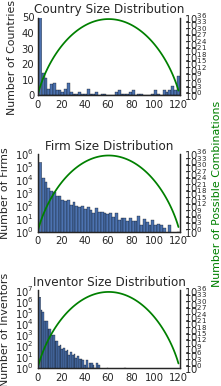

In [127]:
from scipy.misc import comb
f = lambda k: comb(n_classes, k)

fig = figure(figsize=(fig_one_col, fig_one_col*1.618))
n_cols = 1
n_rows = 3
this_ax = 0

this_ax +=1
fig.add_subplot(n_rows, n_cols, this_ax)
hist(countries['Country'].value_counts(), bins=50)
ylabel("Number of Countries")
title("Country Size Distribution")
twinx()
plot(list(map(f,arange(n_classes))), color='green')
xlim(xmin=0, xmax=n_classes)
yscale('log')

#ylabel("Number of Possible Combinations", color='green')

this_ax +=1
fig.add_subplot(n_rows, n_cols, this_ax)
hist(firms['Firm'].value_counts(), bins=50)
ylabel("Number of Firms")
title("Firm Size Distribution")
yscale('log')
twinx()
plot(list(map(f,arange(n_classes))), color='green')
xlim(xmin=0, xmax=n_classes)
yscale('log')

ylabel("Number of Possible Combinations", color='green')

this_ax +=1
fig.add_subplot(n_rows, n_cols, this_ax)
hist(inventors['Inventor'].value_counts(), bins=50)

ylabel("Number of Inventors")
title("Inventor Size Distribution")
yscale('log')
twinx()
plot(list(map(f,arange(n_classes))), color='green')
xlim(xmin=0, xmax=n_classes)
#ylabel("Number of Possible Combinations", color='green')
yscale('log')
xlabel("Number of Classes in History")

fig.tight_layout()
sns.despine(right=False)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
plots = PdfPages(figures_directory+'Manuscript_Figures_%s.pdf'%class_system)
for i in figures:
    print(i)
    plots.savefig(i, bbox_inches='tight')
plots.close()